<a href="https://colab.research.google.com/github/alouwyck/vives_ttk_tallinn/blob/main/intro_ml/Intro_to_Machine_Learning_Exercise_with_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

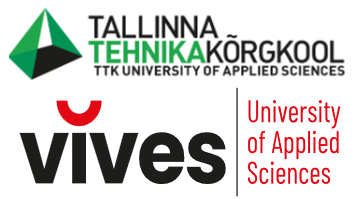<br>

**Erasmus+ Teaching Exchange**<br>
**TTK University of Applied Sciences, Tallinn, Estonia**<br>
8 - 12 December 2025<br><br>
**Guest Lecture at Centre for Sciences**<br>
by Andy Louwyck & Dominique Stove<br>
VIVES University of Applied Sciences, Kortrijk, Belgium

---



---



# **INTRODUCTION TO MACHINE LEARNING WITH PYTHON**

## **Exercise**

Read the `'Students_Passed.csv'` dataset and try to predict as accurate as possible whether or not students will pass the exam based on the hours they have studied.

Answer the following questions:

- Is this a regression or classification problem? Why?
- Which is the independent variable and which is the target?
- What algorithms discussed in this notebook may be applied to solve the problem?
- How can we compare different models? How do we select the best model?
- Do we get a better model when we also include the number of courses followed by the students?
- What is a confusion matrix? Create one to evaluate the final model you've selected!

Although it is good practice to split the dataset, it is not required for this exercise.


### Solution

Let's first read the dataset:

In [ ]:
df = pd.read_csv('Student_Passed.csv')
df.head()

,number_courses,time_study,passed
0,3,4.508,1
1,4,0.096,0
2,4,3.133,1
3,6,7.909,1
4,8,7.811,1


Getting an overview of the features:

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_courses,100.0,5.29000,1.799523,3.000,4.0000,5.000,7.00000,8.000
time_study,100.0,4.07714,2.372914,0.096,2.0585,4.022,6.17925,7.957
passed,100.0,0.50000,0.502519,0.000,0.0000,0.500,1.00000,1.000


There are 100 samples and 3 variables. As we have to predict categorical variable 'passed' which has two classes only, it is a *binary classification* problem. It can be solved using logistic regression and K nearest neighbors. The independent variables are 'time_study' and 'number_courses', the dependent variable is 'passed'. The dataset is balanced, as there are an equal number of positively and negatively labeled samples:




In [ ]:
df.passed.sum(), (1 - df.passed).sum()

(50, 50)

There are no missing values:

In [ ]:
np.any(df.isna())

False

Let's put the features and labels in separate variables:

In [ ]:
X, y = df[['time_study', 'number_courses']].values, df.passed.values

It's always a good idea to visualize the dataset:

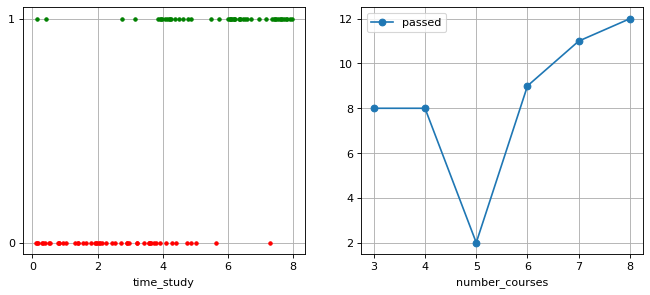

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

b = y.astype(bool)  # convert to apply boolean indexing
ax1.plot(X[b, 0], np.ones(b.sum()), 'g.');
ax1.plot(X[~b, 0], np.zeros((~b).sum()), 'r.');
ax1.grid();
ax1.set_yticks((0, 1))
ax1.set_xlabel('time_study');

df[['number_courses', 'passed']].groupby(['number_courses']).sum().plot(ax=ax2, marker='o');
ax2.grid();

From the left plot, it is concluded that the data points are not perfectly separable using a linear classifier based on study time only, but it is possible to classify them with relatively high accuracy as most red dots are on the left while most green dots are on the right. The right plot shows there is only a weak correlation between the number of courses and the number of students who pass. Therefore, we start considering 'time_study' only.

Let's first try 1D logistic regression; 1D because we only consider 'time_study':

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg1d = LogisticRegression(penalty=None)
logreg1d.fit(X[:, [0]], y)  # [0] as only the first feature 'time_study' is considered
logreg1d.score(X[:, [0]], y)  # accuracy

0.83

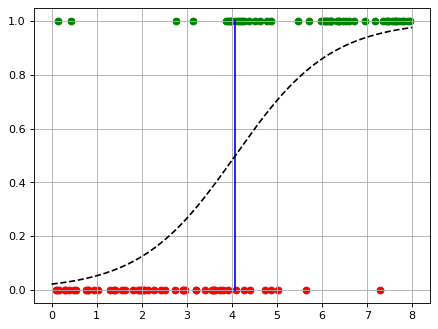

In [ ]:
_, ax = plt.subplots(1, 1)
ax.scatter(X[b, 0], np.ones(y.sum()), color='green');
ax.scatter(X[~b, 0], np.zeros((~b).sum()), color='red');
ax.grid();

threshold = -logreg1d.intercept_.item() / logreg1d.coef_.item()  # determine threshold
ax.plot(threshold * np.ones(2), [0, 1], 'b-');

sigmoid = lambda f: 1 / (1 + np.exp(-f))
f = lambda x: logreg1d.coef_.item() * x + logreg1d.intercept_.item()
x = np.linspace(0, 8, 1000)
ax.plot(x, sigmoid(f(x)), 'k--');

Now let's include 'number_courses' as independent variable. In this case, the logistic regression model is defined as follows:

> $p = \sigma(b + a_1 X_1 + a_2 X_2)$

with $p$ the probability that the label equals 1, $\sigma$ the sigmoid function, $X_1$ the independent variables or features, and $b$ and $a_i$ the parameters.

In [ ]:
logreg2d = LogisticRegression(penalty=None)
logreg2d.fit(X, y)
logreg2d.score(X, y)

0.89

We get a higher score, although including the number of courses does not make the model much more performant, as we already figured out by visualizing the data. As this is a 2D problem, it is still possible to make a scatterplot. Note that in this case, the threshold becomes a separating straight line expressed by the following equation:

> $X_2 = -(b + a_1 X_1) / a_2$

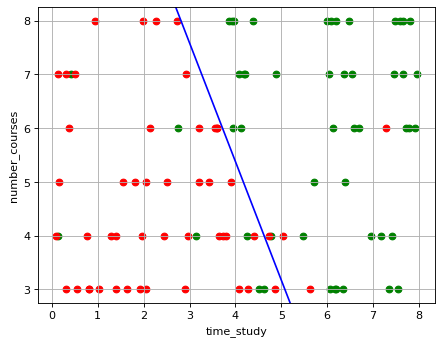

In [ ]:
plt.scatter(X[b, 0], X[b, 1], color='green');
plt.scatter(X[~b, 0], X[~b, 1], color='red');

xl, yl = plt.xlim(), plt.ylim()
xplot = np.array([0, 8])
yplot = -(logreg2d.intercept_.item() + logreg2d.coef_[0][0] * xplot) / logreg2d.coef_[0][1]
plt.plot(xplot, yplot, 'b-');

plt.xlim(xl);
plt.ylim(yl);
plt.xlabel('time_study');
plt.ylabel('number_courses');
plt.grid();

We may also apply the KNN algorithm. Again, we perform it with and without the number of courses. Here, there is one hyperparameter, the number of neighbors K. We evaluate a range of K values for both the 1D and the 2D problem. Finding the optimal value for K is done ideally using a validation set, but this is not asked here, so we don't split the dataset.

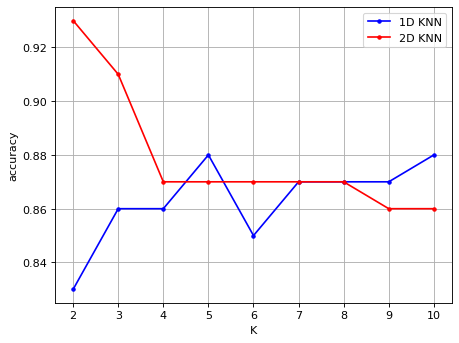

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

acc1d, acc2d = [], []  # list of accuracies for the 1D and 2D problem
Ks = range(2, 11)  # K's ranging from 2 to 10

for K in Ks:  # go through all K's

    # 1D
    knn1d = KNeighborsClassifier(K)
    knn1d.fit(X[:, [0]], y)
    acc1d.append(knn1d.score(X[:, [0]], y))

    # 2D
    knn2d = KNeighborsClassifier(K)
    knn2d.fit(X, y)
    acc2d.append(knn2d.score(X, y))

# plot the result
plt.plot(Ks, acc1d, 'b.-',
         Ks, acc2d, 'r.-');
plt.legend(['1D KNN', '2D KNN']);
plt.xlabel('K');
plt.ylabel('accuracy');
plt.grid();

It is concluded that the KNN model with K = 2 and considering both independent variables gives the highest accuracy, which is also higher than the accurarcy of the 2D logistic regression model. Therefore, this is our final model:

In [ ]:
model = KNeighborsClassifier(2)
model.fit(X, y)
model.score(X, y)

0.93

A **confusion matrix** gives a better overview of the model's performance by displaying counts of true positives, true negatives, false positives, and false negatives based on predictions and actual labels:

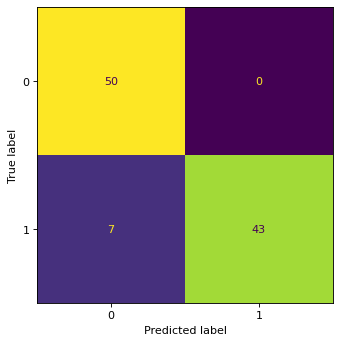

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X, y,
                                      colorbar=False);

We see there are 50 true negatives, which are samples with label 0 that are predicted correctly, and 43 true positives, which are samples with label 1 that are predicted correctly. The sum of both is 93, which gives the accuracy, after dividing this number by 100, which is the total number of samples.

There are no false positives, which are samples that have 1 as predicted label and 0 as true label, and 7 false negatives, which are positive samples misclassified as negative.

Note that the accuracy doensn't distinguish between false negatives and false positives. There are, however, other evaluation metrics such as precision and recall that do. We already mentioned that it is good machine learning practice to evaluate the model before putting it in production using a test set that was not used during training and validation!